# setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from teren import dir_act_utils as dau
from teren import utils as tu
from teren import direction, measure, experiment_context
from transformer_lens import HookedTransformer
from teren.typing import *

device = tu.get_device_str()
print(f"{device=}")

device='cuda'


In [3]:
LAYER = 11
SEQ_LEN = 4
INFERENCE_TOKENS = 12_800
INFERENCE_BATCH_SIZE = INFERENCE_TOKENS // SEQ_LEN
print(f"{INFERENCE_BATCH_SIZE=}")

N_PROMPTS = INFERENCE_BATCH_SIZE


input_ids = dau.get_input_ids(chunk=0, seq_len=SEQ_LEN)[:N_PROMPTS]
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

INFERENCE_BATCH_SIZE=3200
Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
exctx = experiment_context.ExperimentContext(
    model=model,
    layer=LAYER,
    input_ids=input_ids,
    acts_q_range=(0.01, 0.95),
    batch_size=INFERENCE_BATCH_SIZE,
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
SEED = 0
N_DIRS = 1

In [36]:
dir = torch.randn(model.cfg.d_model)
dir /= dir.norm()
dir = direction.Direction(dir, exctx)
dir.act_min, dir.act_max

(1.4906582832336426, 15.54223918914795)

In [37]:
dir.process_measure(measure.jsd_measure)

In [38]:
dir.measurements_by_measure[measure.jsd_measure].selected.shape

torch.Size([370, 3])

In [39]:
matrix_measure = dir.act_matrix_measure(n_act=10, measure=measure.jsd_measure)
matrix_measure.shape

torch.Size([10, 10, 370])

In [40]:
def helper(mid, i, jsd_by_bin, prev_jsd, auc, min_ratio):
    jsd = jsd_by_bin[mid, i]
    auc += (jsd + prev_jsd) / 2
    aul = abs(mid - i) * jsd / 2
    ratio = torch.ones_like(auc)
    mask = (auc > 0) & (aul > 0)
    ratio[mask] = auc[mask] / aul[mask]
    min_ratio = torch.minimum(min_ratio, ratio)
    return auc, min_ratio, jsd


def compute_auc_ratio(jsd):
    n_bins = jsd.shape[0]
    ratio_shape = jsd.shape[2:]
    min_ratios = torch.empty(jsd.shape[1:])
    for mid in range(n_bins):
        min_ratio = torch.full(ratio_shape, float("inf"))
        # from mid to left
        auc = torch.zeros(ratio_shape)
        prev_jsd = torch.zeros(ratio_shape)
        for i in range(mid - 1, -1, -1):
            auc, min_ratio, prev_jsd = helper(mid, i, jsd, prev_jsd, auc, min_ratio)
        # from mid to right
        auc = torch.zeros(ratio_shape)
        prev_jsd = torch.zeros(ratio_shape)
        for i in range(mid + 1, n_bins):
            auc, min_ratio, prev_jsd = helper(mid, i, jsd, prev_jsd, auc, min_ratio)
        min_ratios[mid] = min_ratio
    return min_ratios.min(0)

In [41]:
values, indices = compute_auc_ratio(matrix_measure)
print(values.min())
print(values.shape)

tensor(0.6833)
torch.Size([370])


In [42]:
min_lines = torch.gather(
    matrix_measure,
    index=indices.unsqueeze(0).unsqueeze(0).expand(-1, 10, -1),
    dim=0,
).squeeze()
min_lines.shape

torch.Size([10, 370])

In [43]:
sorted_i = torch.argsort(values)[:50:5]

In [44]:
lines = min_lines[:, sorted_i]
lines.shape

torch.Size([10, 10])

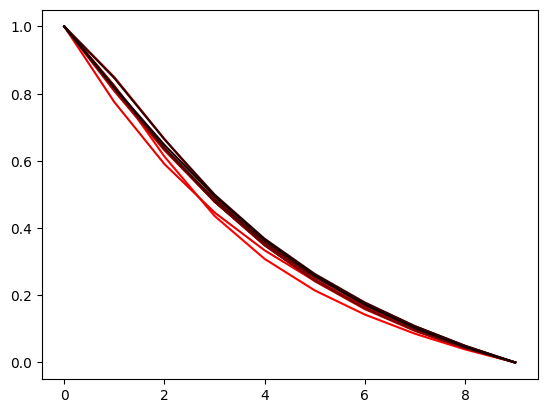

In [45]:
import matplotlib.pyplot as plt

for i, line in enumerate(lines.T):
    plt.plot(line / line.max(), color=(1 - i / 10, 0, 0))